In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines
import re

In [2]:
data = '/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [3]:
#deredden calibration sample
u_cal = (objs["U"]-(4.239*objs["EBV"]))
g_cal = (objs["G"]-(3.303*objs["EBV"]))
i_cal = (objs["I"]-(1.263*objs["EBV"]))
r_cal = (objs["R"]-(2.285*objs["EBV"]))
feh_cal = objs["FEH"]
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal

In [4]:
ret,xedge,yedge,bin = stats.binned_statistic_2d((u_g_cal),(g_r_cal),feh_cal,'median',50)


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [5]:
SMASH_fields = [1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 42, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 68, 149, 150, 156, 176, 177, 178, 246]



In [6]:
#dictionaries to be used in metallicity function
mean_metallicity = {}
std = {}
wt_mean = {}
for i, method in enumerate(("original","uerr","gerr","rerr")):
    mean_metallicity[method] = []
    std[method] = []


In [7]:
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number_transient = [int(i) for i in newstr.split()]
    print("number of initial stars in field "+str(field_number_transient[0])+": "+str(len(objs_new)))
    #print("number of initial stars "+str(len(objs_new)))
    
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))
    
    #append to lists
    #field_number.append(field_number_transient[0])M
    selected = np.where(((g-i)>=0.11)&((g-i)<=0.44)&(g>=21.4)&(g<=22.8)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    #selected = np.where(((g-i)>=-1)&((g-i)<=4)&(g>=14)&(g<=26)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8)&(np.isnan(objs_new['U'])!=True)&(np.isnan(objs_new['G'])!=True)&(np.isnan(objs_new['R'])!=True)&(np.isnan(objs_new['I'])!=True))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    u_g = u-g
    g_r = g-r
    wt_uerr = 1/(uerr**2)
    wt_gerr = 1/(gerr**2)
    wt_rerr = 1/(rerr**2)
    wts = [wt_uerr,wt_gerr,wt_rerr]
    
    #append to list
    #cut_star_count.append(len(cut_u))
    print("number of stars after cuts in field "+str(field_number_transient[0])+": "+str(len(u)))
    #print("number of initial stars "+str(len(objs_new)))

    ind, = np.where(((u_g)>=xedge.min())&((u_g)<=xedge.max())&((g_r)>=yedge.min())&((g_r)<=yedge.max()))
    ix = np.searchsorted(xedge,(u_g)[ind])
    ix = ix - 1
    iy = np.searchsorted(yedge,(g_r)[ind])
    iy = iy - 1
    feh = ret[ix,iy]
    mean_metallicity['original'].append(np.nanmean(feh))
    print("original mean metallicity:",(np.nanmean(feh)))
    std['original'].append(np.nanstd(feh))
    
    
    for i, method in enumerate(('uerr','gerr','rerr')):
        wt = 1/(wts[i]**2)
        wt = wt[ind]
        selected = np.where((np.isnan(feh)!=True))
        feh = feh[selected]
        wt = wt[selected]
        mean_metallicity[method].append((np.sum(wt*feh))/(np.sum(wt)))
        std[method].append(np.nanstd(feh))
        print("weight mean using "+str(method)+': ',((np.sum(wt*feh))/(np.sum(wt))))

    return 0

In [8]:
if __name__=="__main__":
    for number in SMASH_fields:
        metallicity('/Users/amyel/research/SMASH_project/datafiles/SMASH_fields/vsix/starsthree/Field{}_allobj_deep_stars.fits.gz'.format(number))

              

number of initial stars in field 1: 46634
number of stars after cuts in field 1: 3445
original mean metallicity: -1.2104063772287652
weight mean using uerr:  -0.9231112615849125
weight mean using gerr:  -0.6709098220804349
weight mean using rerr:  -1.1577297909364233
number of initial stars in field 2: 61991
number of stars after cuts in field 2: 4099
original mean metallicity: -1.3326770847538194
weight mean using uerr:  -0.9315382715745778
weight mean using gerr:  -1.3356335201136744
weight mean using rerr:  -1.340282708915621
number of initial stars in field 3: 847797
number of stars after cuts in field 3: 75776
original mean metallicity: -1.344519669298292
weight mean using uerr:  -1.2069971307331904
weight mean using gerr:  -1.2931506955055045
weight mean using rerr:  -1.3422736428468438
number of initial stars in field 4: 640420
number of stars after cuts in field 4: 62337
original mean metallicity: -1.3697756987005785
weight mean using uerr:  -1.1906875464269915
weight mean usin

number of initial stars in field 42: 1882163
number of stars after cuts in field 42: 112716
original mean metallicity: -1.128623304324175
weight mean using uerr:  -0.847993113837362
weight mean using gerr:  -1.2414509912389275
weight mean using rerr:  -1.1385187390364597
number of initial stars in field 44: 427557
number of stars after cuts in field 44: 72689
original mean metallicity: -1.6679157550618775
weight mean using uerr:  -1.4128713783536426
weight mean using gerr:  -1.6647349583740483
weight mean using rerr:  -1.5716150131581574
number of initial stars in field 46: 1304849
number of stars after cuts in field 46: 306121
original mean metallicity: -1.3650111546524988
weight mean using uerr:  -1.1154578620781403
weight mean using gerr:  -1.3587288295338062
weight mean using rerr:  -1.3671881094807379
number of initial stars in field 48: 2145968
number of stars after cuts in field 48: 158531
original mean metallicity: -1.2013809457039626
weight mean using uerr:  -1.225558560050268

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal


number of stars after cuts in field 50: 423
original mean metallicity: -1.376974723031444
weight mean using uerr:  -1.2376795928641928
weight mean using gerr:  -1.569743279664325
weight mean using rerr:  -1.5285808033174855
number of initial stars in field 51: 1574573
number of stars after cuts in field 51: 267795
original mean metallicity: -1.2656220236416222
weight mean using uerr:  -1.1248017346767563
weight mean using gerr:  -1.257976829276771
weight mean using rerr:  -1.2526575199936996
number of initial stars in field 52: 62890
number of stars after cuts in field 52: 2573
original mean metallicity: -1.6215232423352963
weight mean using uerr:  -1.380781692836376
weight mean using gerr:  -1.574942099996599
weight mean using rerr:  -1.7341447143741695
number of initial stars in field 53: 396092
number of stars after cuts in field 53: 137902
original mean metallicity: -1.407828734133084
weight mean using uerr:  -1.2038184856061318
weight mean using gerr:  -1.4151718397777315
weight m

In [9]:
#add mean metallicity key/value pair 
###this is the original calibration metallicity with a +.6 dex offset applied
mean_metallicity['offset'] = [i + 0.6 for i in mean_metallicity['original']]
std['offset'] = std['original']

In [10]:
mean_metallicity

{'original': [-1.2104063772287652,
  -1.3326770847538194,
  -1.344519669298292,
  -1.3697756987005785,
  -1.4391902524409637,
  -1.3548760797608157,
  -1.533851079028867,
  -1.4249517799995113,
  -1.4219550695014265,
  -1.4122499051840205,
  -1.4184366165133964,
  -1.3598008237889816,
  -1.4279941368778994,
  -1.4204594858924267,
  -1.3901167898550524,
  -1.7767305484949014,
  -1.411643056184288,
  -1.773102516317787,
  -1.3908817550506105,
  -1.3081523438391431,
  -1.3732293600053345,
  -1.316709947447636,
  -1.3625181274809752,
  -1.279078756542376,
  -1.428038583625583,
  -1.217447321537533,
  -1.3233642191349972,
  -1.400878464527574,
  -1.1169564771942422,
  -1.2336909967991272,
  -1.2243245711015747,
  -1.128623304324175,
  -1.6679157550618775,
  -1.3650111546524988,
  -1.2013809457039626,
  -1.1940813597913609,
  -1.376974723031444,
  -1.2656220236416222,
  -1.6215232423352963,
  -1.407828734133084,
  -1.438537413500444,
  -1.35493968121379,
  -1.8379286875171652,
  -1.606721704

In [12]:
#make table of different mean metallicities of each field and standard deviations
table_array = [(np.array(SMASH_fields))]

for i, method in enumerate(('offset','original','uerr','gerr','rerr')):
    table_array.append(np.array(mean_metallicity[method]).round(decimals=3))
    table_array.append(np.array(std[method]).round(decimals=3))
    
table = Table(table_array,names=('Field Number','Fe/H Original +.6 dex','Offset Std','Original','Original Std','uerr weight','uerr Std','gerr weight','gerr Std','rerr weight','rerr Std'))
ascii.write(table,'MetallicityTable_weightedavg.csv',format='csv', fast_writer=False)

 

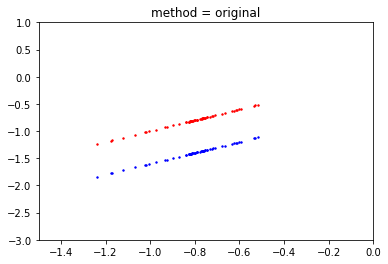

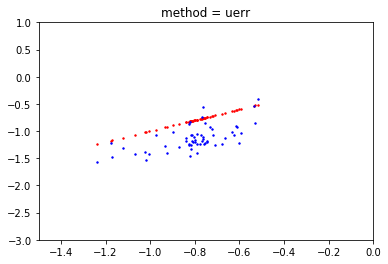

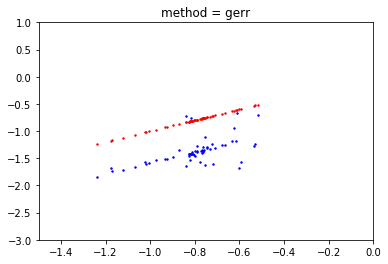

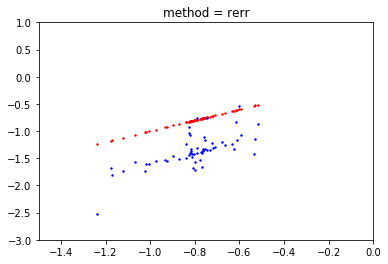

In [13]:
#plot original Fe/H w/ +.6 offset versus all the different methods
for i, method in enumerate(('original','uerr','gerr','rerr')):
    plt.scatter(mean_metallicity['offset'],mean_metallicity['offset'],s=2,c='r')
    plt.scatter(mean_metallicity['offset'],mean_metallicity[method],s=2,c='b')
    plt.title('method = {}'.format(method))
    plt.xlim(-1.5,0)
    plt.ylim(-3,1) 
    plt.show(block=False)
    

    